# Process raw Osmosis swap data import

[See also Osmosis asset info documentation](https://docs.osmosis.zone/developing/assets/asset-info.html).

In [62]:
import pandas as pd
import numpy as np

fpath = "/Users/moo/code/ts/hackatom-2022/swaps.csv"

# Define CSV column types
dtype = {
    "block_number": np.int32,
    "timestamp": np.int32,
    "pool_id": np.int32,
    "token_in": str,
    "token_out": str,
    "token_in_amount": np.float64,
    "token_out_amount": np.float64,
}

df = pd.read_csv(fpath, dtype=dtype)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index("timestamp", inplace=True, drop=False)

df


,block_number,timestamp,pool_id,token_in,token_out,token_in_amount,token_out_amount
timestamp,,,,,,,
2021-12-25 00:12:25,2522560,2021-12-25 00:12:25,605,ibc/B9E0A1A524E98BB407D3CED8720EFEFD186002F90C...,uosmo,9.341900e+10,21116362.0
2021-12-25 00:12:31,2522561,2021-12-25 00:12:31,1,uosmo,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,1.336698e+06,275489.0
2021-12-25 00:12:37,2522562,2021-12-25 00:12:37,1,ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEAD...,uosmo,2.000000e+06,9646039.0
2021-12-25 00:12:37,2522562,2021-12-25 00:12:37,560,uosmo,ibc/BE1BB42D4BE3C30D50B68D7C41DB4DFCE9678E8EF8...,3.822892e+07,211282980.0
2021-12-25 00:12:51,2522564,2021-12-25 00:12:51,481,uosmo,ibc/5973C068568365FFF40DEDCF1A1CB7582B6116B731...,2.500000e+07,128144457.0
...,...,...,...,...,...,...,...
2022-01-14 15:29:32,2796461,2022-01-14 15:29:32,621,uosmo,ibc/307E5C96C8F60D1CBEE269A9A86C0834E1DB06F2B3...,1.000000e+07,495879400.0
2022-01-14 15:29:38,2796462,2022-01-14 15:29:38,560,uosmo,ibc/BE1BB42D4BE3C30D50B68D7C41DB4DFCE9678E8EF8...,1.326231e+06,12203714.0
2022-01-14 15:29:38,2796462,2022-01-14 15:29:38,619,ibc/EA4C0A9F72E2CEDF10D0E7A9A6A22954DB3444910D...,uosmo,2.156122e+08,10002368.0


Split swaps by trading pair (pool)

In [63]:
pool_df = df.groupby("pool_id")
print(f"We have total {len(pool_df.groups.keys())} pools")

We have total 327 pools


# Swap counts by pool id

array([[<AxesSubplot:title={'center':'pool_id'}>]], dtype=object)

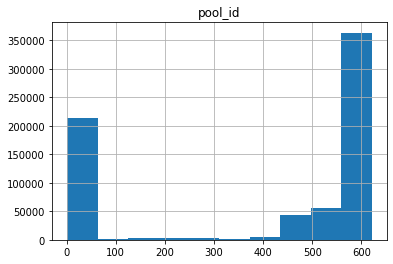

In [64]:
df.hist(column="pool_id")

# Top pools


In [65]:
print(pool_df.groups.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 33, 34, 36, 39, 42, 43, 45, 48, 54, 58, 66, 70, 78, 80, 84, 85, 86, 88, 89, 91, 93, 97, 105, 110, 112, 115, 118, 119, 123, 124, 125, 126, 128, 130, 133, 134, 136, 137, 142, 145, 146, 151, 155, 158, 159, 161, 162, 165, 166, 167, 170, 171, 172, 174, 180, 183, 185, 190, 191, 193, 197, 199, 200, 203, 204, 207, 210, 212, 215, 216, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 244, 245, 247, 248, 249, 251, 253, 254, 255, 256, 257, 258, 261, 262, 263, 265, 266, 269, 271, 273, 277, 279, 282, 283, 284, 285, 286, 287, 289, 292, 294, 301, 305, 306, 307, 308, 309, 312, 313, 314, 315, 318, 319, 320, 322, 324, 329, 330, 333, 336, 337, 338, 339, 342, 343, 345, 347, 348, 350, 353, 355, 362, 365, 366, 370, 372, 374, 375, 376, 377, 380, 381, 383, 384, 385, 388, 390, 391, 395, 396, 397, 398, 400, 401, 406, 409, 410, 411, 412, 414, 415, 416, 417, 422, 425, 42

In [66]:
from collections import Counter

swap_counts = Counter({pid: len(df.loc[df["pool_id"]==pid]) for pid in pool_df.groups.keys()})

for pool_id, count in swap_counts.most_common(6):
    pool_data = df.loc[df["pool_id"]== pool_id ]
    first_swap = pool_data.iloc[0]
    print(f"Pool id {pool_id} {first_swap['token_in']}-{first_swap['token_out']} has {count:,} swaps")

Pool id 1 uosmo-ibc/27394FB092D2ECCD56123C74F36E4C1F926001CEADA9CA97EA622B25F41E5EB2 has 114,771 swaps
Pool id 560 uosmo-ibc/BE1BB42D4BE3C30D50B68D7C41DB4DFCE9678E8EF8C539F6E6A9345048894FCC has 97,342 swaps
Pool id 580 ibc/46B44899322F3CD854D2D46DEEF881958467CDD4B3B10086DA49296BBED94BED-ibc/BE1BB42D4BE3C30D50B68D7C41DB4DFCE9678E8EF8C539F6E6A9345048894FCC has 52,819 swaps
Pool id 605 ibc/B9E0A1A524E98BB407D3CED8720EFEFD186002F90C1B1B7964811DD0CCC12228-uosmo has 31,580 swaps
Pool id 561 uosmo-ibc/0EF15DF2F02480ADE0BB6E85D9EBB5DAEA2836D3860E9F97F9AADE4F57A31AA0 has 30,933 swaps
Pool id 497 ibc/46B44899322F3CD854D2D46DEEF881958467CDD4B3B10086DA49296BBED94BED-uosmo has 23,921 swaps


# Calculate price and value for each swap

Draw candles for pool 1. This is [ATOM-OSMO pair](https://docs.osmosis.zone/developing/assets/asset-info.html).

- Determine direction of each swap event
- Calculate price as ATOM/OSMO and swap volume

In [67]:
pool_id = 1
pair_data = df.loc[df["pool_id"] == pool_id]

def calculate_price(row: pd.Series):
    if row["token_in"] == "uosmo":
        # Buying ATOM with OSMO
        price = row["token_out_amount"] / row["token_in_amount"]
    else:
        # Selling OSMO for ATOM
        price = row["token_in_amount"] / row["token_out_amount"]

    return price

def calculate_value(row: pd.Series):
    # Get volume in OSMO
    if row["token_in"] == "uosmo":
        # Buying ATOM with OSMO
        vol = row["token_in_amount"]
    else:
        # Selling OSMO for ATOM
        vol = row["token_out_amount"]

    return vol


pair_data["price"] = pair_data.apply(calculate_price, axis=1)
pair_data["value"] = pair_data.apply(calculate_value, axis=1)
# pair_data.head(10)

/var/folders/tx/50wn88yd40v2_6_7fvfr98z00000gn/T/ipykernel_16274/1106787536.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_data["price"] = pair_data.apply(calculate_price, axis=1)
/var/folders/tx/50wn88yd40v2_6_7fvfr98z00000gn/T/ipykernel_16274/1106787536.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_data["value"] = pair_data.apply(calculate_value, axis=1)


In [68]:
# Convert trades to candles


In [69]:
from eth_defi.research.candle import convert_to_ohlcv_candles

candles = convert_to_ohlcv_candles(pair_data)

candles.head(10)

/Users/moo/Library/Caches/pypoetry/virtualenvs/dex-ohlcv-qY1n4duk-py3.9/lib/python3.9/site-packages/eth_defi/research/candle.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[timestamp_index_column] = pd.to_datetime(df[timestamp_index_column])


,open,high,low,close,volume
timestamp,,,,,
2021-12-25,0.206097,0.250000,0.187500,0.200395,1.359263e+12
2021-12-26,0.200395,0.201743,0.190530,0.191026,1.565796e+12
2021-12-27,0.191026,0.205486,0.178571,0.203956,2.591825e+12
2021-12-28,0.203952,0.208725,0.202532,0.206895,1.061533e+12
2021-12-29,0.208142,0.212329,0.166667,0.204094,1.680099e+12
2021-12-30,0.202871,0.214286,0.166667,0.200005,1.702391e+12
2021-12-31,0.198806,0.200180,0.191476,0.193114,2.048829e+12
2022-01-01,0.191960,0.200000,0.160000,0.191168,1.963509e+12
2022-01-02,0.191163,0.200000,0.187500,0.192852,1.604234e+12


# Draw candle chart



In [71]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

candlesticks = go.Candlestick(
    x=candles.index,
    open=candles['open'],
    high=candles['high'],
    low=candles['low'],
    close=candles['close'],
    showlegend=False
)

volume_bars = go.Bar(
    x=candles.index,
    y=candles['volume'],
    showlegend=False,
    marker={
        "color": "rgba(128,128,128,0.5)",
    }
)

fig = go.Figure(candlesticks)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(candlesticks, secondary_y=True)
fig.add_trace(volume_bars, secondary_y=False)
fig.update_layout(title="ATOM/OSMO pool after launch", height=800)
fig.update_yaxes(title="Price ATOM/OSMO", secondary_y=True, showgrid=True)
fig.update_yaxes(title="Volume OSMO", secondary_y=False, showgrid=False)
fig.show()